## Import modules and functions

In [1]:
import numpy as np
import os
from nd2reader import ND2Reader
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_scalebar.scalebar import ScaleBar
import scipy.ndimage as ndi
from skimage.filters import rank 
from scipy.signal import butter, lfilter
import scipy.misc as misc
from skimage import exposure
from PIL import Image
import colorcet as cc
from scipy.misc import toimage
import matplotlib.colors as clr
import pandas as pd
import seaborn as sns
from scipy import stats
import cv2
from pyspark import SparkContext, SparkConf
import skimage
from pathlib import Path

def mean2(x):
    y = np.sum(x) / np.size(x);
    return y
def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / np.sqrt((a*a).sum() * (b*b).sum());
    return r
from copy import deepcopy
from skimage.filters import threshold_otsu,threshold_li
import glob
from IPython.display import clear_output
import scipy.io as spio
import matplotlib.ticker as ticker

## Specify experiment directory

In [2]:
expdir='/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Fixed culture/Golgi_block/' #master folder
protein="TNR" #TNR,Agg,WFA,HABP

## Make a dictionary to store the results

In [6]:
results = {"filename":[],
           "ecmchannelno":[],
           "Manual neurites mask from matlab GUI":[],
           "exp condition":[],
           "ECM mean intensity after bg subtraction: matlab manual neurites mask only":[]}
path = os.path.dirname(expdir)  
outputFolder = os.path.dirname(expdir + "/new/")
filelist = []
for root, _, filenames in os.walk(path):
     for filename in filenames:
         filelist.append(os.path.join(root, filename))      
for i in range(0,len(filelist)):
    if ("homer" in str(filelist[i]))==False:
        #if ("647" in str(filelist[i]))==False:
            #if ("580" in str(filelist[i]))==False:
                if ("635" in str(filelist[i]))==False:
                    if ("Soma_v_dendrite_analysis" in str(filelist[i]))==False:
                        if filelist[i].endswith(".nd2"): 
                            results["filename"].append(filelist[i])
                            results["exp condition"].append(filelist[i].split('/')[-2])
                            results["ecmchannelno"].append(1)    

## Display random image

Image name: dmso_2_003.nd2
Experimental condition: DMSO


(array([-100.,    0.,  100.,  200.,  300.,  400.,  500.,  600.]),
 <a list of 8 Text yticklabel objects>)

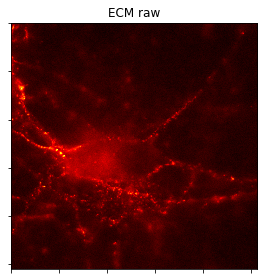

In [7]:
randomno=np.random.randint(1,len(results["filename"]))
ecm_channel_no=results["ecmchannelno"][randomno]

with ND2Reader(results["filename"][randomno]) as images:
    print("Image name:",results["filename"][randomno].split('/')[-1])
    print("Experimental condition:",results["exp condition"][randomno])
    ecm_image=images[ecm_channel_no-1]
    synapse_image=images[ecm_channel_no-1]

figure=plt.figure(figsize=(15,15))
figure.add_subplot(131)
plt.imshow(ecm_image,interpolation='none',cmap='hot')
plt.title('ECM raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)

## Load manual masks from Matlab GUI

In [8]:
for im in range(0,len(results["filename"])): 
    file=results["filename"][im][:-4]+'_dendritemask.mat'
    from pathlib import Path
    my_file = Path(file)
    if my_file.exists():
        print(file)
        mat = spio.loadmat(file, squeeze_me=True)
        mask=mat['totMask']>0.99
        results["Manual neurites mask from matlab GUI"].append(mask)
    else:
        results["Manual neurites mask from matlab GUI"].append(np.nan)
clear_output()        
print("Done!")

Done!


## Batch analysis

In [11]:
print('Total number of images: ' + str(len(results['filename'])))

for i in range(0,len(results["filename"])): 
    print('Calculating image no ' + str(i+1) + ' out of' + str(len(results["filename"])))
    #read the image
    ecm_channel_no=results["ecmchannelno"][i]
    with ND2Reader(results["filename"][i]) as images:
        ecm_image=images[ecm_channel_no-1]
    #convert to numpy array - a format easier to manipunuclei with code
    ecm_image=ecm_image.astype(np.int16)
    
    
    ###################analyses for the raw images -before processing##############
    #read masks
    matlab_dendritesmask=results["Manual neurites mask from matlab GUI"][i]
    if type(matlab_dendritesmask)==np.ndarray:
        flag=True
    #images after background subtraction
    #for ecm image
    if flag==True:
        ecm_matlabdendritesmasked_bgreduced=deepcopy(ecm_image)
        bg_matlabdendritesmask=np.mean(ndi.median_filter(ecm_image[matlab_dendritesmask],size=5))+0*np.std(ndi.median_filter(ecm_image[matlab_dendritesmask],size=5))
        ecm_matlabdendritesmasked_bgreduced=np.subtract(ecm_matlabdendritesmasked_bgreduced,bg_matlabdendritesmask)
        ecm_matlabdendritesmasked_bgreduced[ecm_matlabdendritesmasked_bgreduced<0]=0
        ecm_matlabdendritesmasked_bgreduced[~matlab_dendritesmask]=0
    ##################################################################################    

#append the final results to the dictionary:
    if flag==True:
        results["ECM mean intensity after bg subtraction: matlab manual neurites mask only"].append(np.nanmean(ecm_matlabdendritesmasked_bgreduced[matlab_dendritesmask]))
    clear_output()
    flag=False
os.system('say "Finished batch analyzing"')
print('Done!')

Done!


## Make dataframe

In [12]:
df=pd.DataFrame(results)

## Add columns with labels

In [13]:
df2=deepcopy(df)
df2.loc[df2['exp condition'].str.contains('refeldin'), 'Drug'] = 'Brefeldin'
df2.loc[df2['exp condition'].str.contains('DMSO'), 'Drug'] = 'DMSO'
df2.loc[df2['exp condition'].str.contains('dmso'), 'Drug'] = 'DMSO'
df2.loc[df2['exp condition'].str.contains('onensin'), 'Drug'] = 'Monensin'

df2["Dye"]='None'
df2.loc[df['filename'].str.contains('550'),"Dye"]='Atto 550'
df2.loc[df['filename'].str.contains('647'),"Dye"]='Atto 647N'
df2.loc[df['filename'].str.contains('580'),"Dye"]='STAR 580'
df2["expname"]="None"
for i in range(0,len(df2)):
    df2["expname"][i]=df2["filename"][i].split("/")[:-2][-1]

/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


## Backup

In [14]:
df2.to_pickle(expdir+'20191119_golgiblock_df2.pkl')

## Dataframe with means of each experiment

In [16]:
var="ECM mean intensity after bg subtraction: matlab manual neurites mask only"

means={"expname":[],"drug":[],"0 to 1 intensity normd to dio mean":[]}

dfonlyorange=df2#[df2["Dye"]!="Atto 647N"]
for exp in dfonlyorange["expname"].unique():
    dfcalc=dfonlyorange[dfonlyorange["expname"]==exp]
    
    means["expname"].append(exp)
    means["drug"].append('DMSO')
    dfcalc2=dfcalc[dfcalc["Drug"]=="DMSO"]
    diomean=dfcalc2[var].mean()
    means["0 to 1 intensity normd to dio mean"].append(1)
    
    means["expname"].append(exp)
    means["drug"].append('Monensin')
    dfcalc2=dfcalc[dfcalc["Drug"]=="Monensin"]
    means["0 to 1 intensity normd to dio mean"].append(dfcalc2[var].mean()/diomean)
    
    means["expname"].append(exp)
    means["drug"].append('Brefeldin')
    dfcalc2=dfcalc[dfcalc["Drug"]=="Brefeldin"]
    means["0 to 1 intensity normd to dio mean"].append(dfcalc2[var].mean()/diomean)
dfmeans=pd.DataFrame(means)

## ttests

In [21]:
var="0 to 1 intensity normd to dio mean"

dmso=dfmeans[dfmeans["drug"]=="DMSO"][var].dropna()
monensin=dfmeans[dfmeans["drug"]=="Monensin"][var].dropna()
brefeldin=dfmeans[dfmeans["drug"]=="Brefeldin"][var].dropna()

[stat,pval_dmso_monen]=stats.ttest_ind(monensin.dropna(), dmso.dropna())
[stat,pval_dmso_bref]=stats.ttest_ind(brefeldin.dropna(), dmso.dropna())
[stat,pval_monen_bref]=stats.ttest_ind(brefeldin.dropna(), monensin.dropna())

pval_dmso_monen=pval_dmso_monen*3
pval_dmso_bref=pval_dmso_bref*3

print(pval_dmso_monen)
print(pval_dmso_bref)

0.00023765286386387148
4.4108815642786815e-06
0.0698985626943612


## Plot

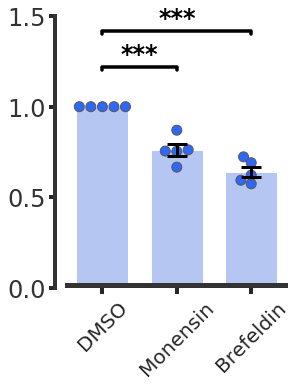

In [26]:
sns.set(font_scale=2.5)
sns.set_style("ticks")
sns.set_palette("Set2")
from matplotlib import ticker

y="0 to 1 intensity normd to dio mean"
fig=plt.figure(figsize=(4,5))
palette={"Monensin": "#adadad",
         "All, flat": "#adadad",
         "New, dmso, mushroom":"#adadad",
         "New, dmso, flat":"#adadad",
        "New, bic, mushroom":"#abc2fc",
         "New, bic, flat":"#abc2fc"}
order=["DMSO","Monensin","Brefeldin"]

g=sns.barplot(x="drug",y=y,data=dfmeans,
            order=order,color="#abc2fc",ci=None)

g=sns.swarmplot(x="drug",y=y,data=dfmeans,size=10,color="#2F67F8",linewidth=1)

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value        
        # we change the bar width
        patch.set_width(new_value)
        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)
change_width(g, .7)

plt.errorbar(x=[1,2],
             y=[
             dfmeans[dfmeans["drug"]=="Monensin"][y].mean(),
             dfmeans[dfmeans["drug"]=="Brefeldin"][y].mean()],
             yerr=[
             dfmeans[dfmeans["drug"]=="Monensin"][y].sem(),
             dfmeans[dfmeans["drug"]=="Brefeldin"][y].sem()],
             xerr=None,ecolor='black',fmt='none',capsize=10,linewidth=3,
             capthick=3,zorder=10,
            alpha=1)

plt.ylim([0,1.5])
plt.axhline(0, color='#333333',alpha=1,linewidth=10)
g.xaxis.set_tick_params(width=4)
g.yaxis.set_tick_params(width=4)
plt.rcParams['font.sans-serif'] = 'Helvetica'
for axis in ['top','bottom','left','right']:
  g.spines[axis].set_linewidth(4)
  g.spines[axis].set_color('#333333')
  g.spines[axis].set_alpha(1)
offsets={"left":10,"bottom":0}
trims={"left":True,"bottom":False,"right":False}
sns.despine(ax=g,right=True,top=True,bottom=True,trim=trims,offset=offsets)
g.set_ylabel('')
g.set_xlabel('',color='#333333',alpha=.7)
plt.xticks(g.get_xticks(),
           rotation=45,size=20)
plt.yticks(g.get_yticks(),size=24,color='#333333')
g.grid(False)

x1, x2 = 0,1
y= 1.2
h=0.02
col='black'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3.5, c=col)
plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col,size=24, weight='bold')

x1, x2 = 0,2
y= 1.4
h=0.02
col='black'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3.5, c=col)
plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col,size=24, weight='bold')

diri="/Volumes/Macintosh HD/Users/taldankovich/Downloads/figures/"
fig.savefig(diri+'SuppFig9_golgiblock.svg', bbox_inches='tight', format='svg')